In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from sklearn.linear_model import Ridge, Lasso
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import os
import torch
import matplotlib.pyplot as plt
import fnmatch
from utils.helper import make_cmap
from tqdm import tqdm

cmap = make_cmap()

# Load a subset of the data

In [4]:
path = '/home/nibdombe/deep_eit/data/processed/all_rho'
cases = os.listdir(path)
cases = [case for case in cases if fnmatch.fnmatch(case, 'case_TCIA*')]

In [5]:
# split into training, validation and test
cases_number = [int(case.split("_")[-2]) for case in cases]
cases_number = [
    case_number
    for case_number in cases_number
    if case_number > 400 and case_number < 450
]
cases_number.sort()
test_cases = [
    "case_TCIA_" + str(case_number) + "_0" for case_number in cases_number
]
# remove test cases
cases = [case for case in cases if case not in test_cases]
number_cases = len(cases)
number_training_cases = int(number_cases * 0.9)

train_cases = cases[:number_training_cases]
val_cases = cases[number_training_cases:]

In [6]:
def load_data(cases):
    signals = []
    targets = []

    for case in cases:
        files = os.listdir(os.path.join(path, case))
        files = [file for file in files if file.endswith('.npz')]
        files = [os.path.join(path, case, file) for file in files]
        for file in files:
            data = np.load(file)
            signals.append(data['signals'].reshape(1, -1))
            point_levels_3d = data['targets'].shape[0]
            levels = np.arange(point_levels_3d)
            electrode_levels = np.linspace(levels[1], levels[-2], 4).astype(int)
            targets.append(data['targets'][electrode_levels])
    targets = np.array(targets).reshape(-1, 4*512*512)
    signals = np.array(signals).reshape(-1, 4*208)
    return signals, targets

In [7]:
X_train, y_train = load_data(train_cases)
X_val, y_val = load_data(val_cases)
X_test, y_test = load_data(test_cases)

# normalize the data
X_train = (X_train - X_train.mean(axis=0)) / X_train.std(axis=0)
X_val = (X_val - X_train.mean(axis=0)) / X_train.std(axis=0)
X_test = (X_test - X_train.mean(axis=0)) / X_train.std(axis=0)

## Ridge

In [111]:
# Create and fit the Ridge regression model
ridge_model = Ridge(alpha=1.0)  # Alpha is the regularization strength
ridge_model.fit(X_train, y_train)  # Train the model to map X to the flattened images

Ridge()

In [112]:
# Predict a new image 
ridge_pred_flattened = ridge_model.predict(X_val)  # Predicted flattened image

# Reshape the predicted image back to 2D (512x512)
ridge_pred_image = ridge_pred_flattened.reshape(-1, 4, 512, 512)
y_gt = y_val.reshape(-1, 4, 512, 512)

## Lasso

In [96]:
# Create and fit the Lasso regression model
lasso_model = Lasso(alpha=1.0)  # Alpha is the regularization strength
lasso_model.fit(X_train, y_train)  # Train the model to map X to the flattened images

In [ ]:
# Predict a new image 
lasso_pred_flattened = lasso_model.predict(X_val)  # Predicted flattened image

# Reshape the predicted image back to 2D (512x512)
lasso_pred_image = lasso_pred_flattened.reshape(-1, 4, 512, 512)
y_gt = y_val.reshape(-1, 4, 512, 512)

In [ ]:
subject = 3
level = 0

fig, axes = plt.subplots(1, 3, figsize=(10, 5))
# Visualize the predicted image
axes[0].imshow(y_gt[subject,level], cmap=cmap, vmin=0, vmax=0.7)
axes[1].imshow(ridge_pred_image[subject,level], cmap=cmap, vmin=0, vmax=0.7)
axes[2].imshow(lasso_pred_image[subject,level], cmap=cmap, vmin=0, vmax=0.7)

axes[0].axis('off')
axes[1].axis('off')
axes[2].axis('off')

axes[0].set_title("Ground Truth")
axes[1].set_title("Ridge Predicted Image")
axes[2].set_title("Lasso Predicted Image")
plt.show()

## with PCA

In [113]:

# Apply PCA to reduce dimensionality of the images
pca = PCA(n_components=100)  # Reduce to 100 dimensions
pca.fit(y_train) 
pca_train = pca.transform(y_train)  # Shape: (N, 100)
pca_val = pca.transform(y_val)  # Shape: (N, 100)
pca_test = pca.transform(y_test)  # Shape: (N, 100)

# Train a Ridge regression model on the reduced images
pca_ridge_model = Ridge(alpha=1.0)
pca_ridge_model.fit(X_train, pca_train)

Ridge()

In [114]:
# Predict a reduced-dimensional image and reconstruct the full image
pca_pred = pca_ridge_model.predict(X_val)
pca_ridge_pred_image = pca.inverse_transform(pca_pred)  # Reconstruct the full image

# Reshape and visualize the predicted image
pca_ridge_pred_image = pca_ridge_pred_image.reshape(-1, 4, 512, 512)

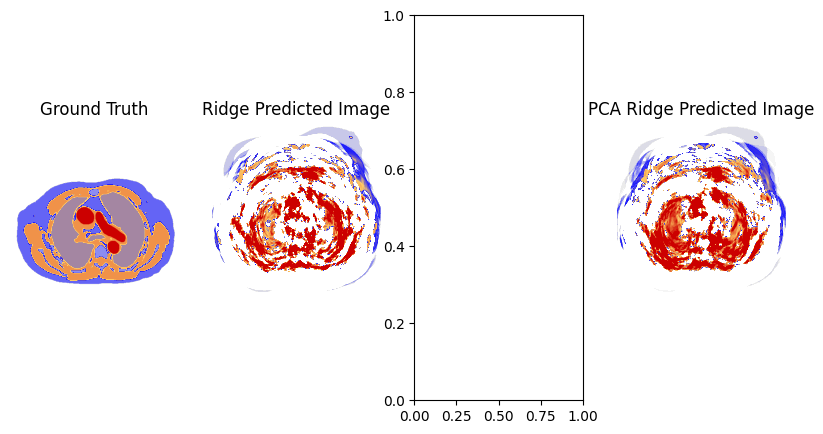

In [115]:
subject = 3
level = 0

fig, axes = plt.subplots(1, 4, figsize=(10, 5))
# Visualize the predicted image
axes[0].imshow(y_gt[subject,level], cmap=cmap, vmin=0, vmax=0.7)
axes[1].imshow(ridge_pred_image[subject,level], cmap=cmap, vmin=0, vmax=0.7)
# axes[2].imshow(lasso_pred_image[subject,level], cmap=cmap, vmin=0, vmax=0.7)
axes[3].imshow(pca_ridge_pred_image[subject,level], cmap=cmap, vmin=0, vmax=0.7)

axes[0].axis('off')
axes[1].axis('off')
# axes[2].axis('off')
axes[3].axis('off')

axes[0].set_title("Ground Truth")
axes[1].set_title("Ridge Predicted Image")
# axes[2].set_title("Lasso Predicted Image")
axes[3].set_title("PCA Ridge Predicted Image")

plt.show()

## Total Variation Regularization

In [2]:
from hydra import compose, initialize
from omegaconf import OmegaConf, DictConfig
from data_processing.dataset_3d import load_dataset_3d
from data_processing.helper import sort_filenames
from utils.helper import get_all_cases
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader

In [3]:
with initialize(
    version_base=None, config_path='cfg', job_name="test"
):
    cfg = compose(config_name="config")

In [4]:
cases = get_all_cases(cfg, base_dir='', use_raw=True)


In [5]:
train_dataset, val_dataset, test_dataset = load_dataset_3d(cases,
            resolution=cfg.data.resolution, 
            base_dir = '',
            raw_data_folder=cfg.data.raw_data_folder, 
            processed_data_folder='data/processed/all_rho',
            dataset_data_folder=cfg.data.dataset_data_folder,
            name_prefix=cfg.data.name_prefix,
            write_dataset=False, write_npz=True, 
            overwrite_npz=False, n_sample_points=cfg.learning.training.sample_points,
            apply_rotation=False,
            apply_subsampling=False,
            apply_translation = False,
            translation_x=cfg.data.translation_x, translation_y=cfg.data.translation_y, translation_z=cfg.data.translation_z,
            point_levels_3d=cfg.data.point_levels_3d,
            multi_process=cfg.data.multi_process, num_workers=cfg.data.num_workers,
            signal_norm='all',
            normalize_space='xy',
            )
test_dataset.case_files = sort_filenames(test_dataset.case_files)

Using 128 workers.


In [6]:
# Function to calculate the total variation (TV) loss
def total_variation_loss(y_pred):
    """
    Calculate the total variation loss which penalizes large differences between adjacent pixels.
    Args:
        y_pred (torch.Tensor): The predicted image (batch_size, 1, height, width)
    Returns:
        torch.Tensor: The total variation loss
    """
    # Shifted images to calculate difference between adjacent pixels
    diff_i = torch.abs(y_pred[:, :, :-1, :] - y_pred[:, :, 1:, :])  # Vertical differences
    diff_j = torch.abs(y_pred[:, :, :, :-1] - y_pred[:, :, :, 1:])  # Horizontal differences

    # Total variation loss is the sum of differences
    tv_loss = torch.sum(diff_i) + torch.sum(diff_j)
    return tv_loss

# Example model and loss function
class SimpleImageModel(nn.Module):
    def __init__(self):
        super(SimpleImageModel, self).__init__()
        # Define a simple linear model (or use more complex CNN)
        self.fc = nn.Linear(208*4, 4*512*512)

    def forward(self, x):
        x = self.fc(x)  # Shape (batch_size, 512 * 512)
        x = x.view(-1, 4, 512, 512)  # Reshape into image (batch_size, 1, 512, 512)
        return x


In [37]:
isinstance(model, SimpleImageModel)

True

In [8]:
# Create an instance of the model
model = SimpleImageModel()
model.to('cuda')

epochs = 30
batch_size = 10
lambda_tv = 0.000000001  # Weight of TV regularization term

optimizer = Adam(model.parameters(), lr=0.0001)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [25]:
training_linear_model(model, train_dataloader, val_dataloader, epochs, optimizer, lambda_tv)

  0%|          | 0/30 [00:00<?, ?it/s]

## Testing

In [9]:
model = SimpleImageModel()
model.load_state_dict(torch.load("outputs/linear/model_TV.pt")["model_state_dict"])
model.to('cuda')

SimpleImageModel(
  (fc): Linear(in_features=832, out_features=1048576, bias=True)
)

In [10]:
batch_size = 50
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


model.eval()
torch.no_grad()
epoch_loss = []
epoch_loss_mse = []
epoch_loss_tv = []
preds = []
gt = []

for _, signals, electrode, _, targets, _ in test_dataloader:
    tmp_batch_size = signals.shape[0]
    targets = targets.reshape(tmp_batch_size, -1, 512, 512)
    point_levels_3d = targets.shape[1]
    levels = np.arange(point_levels_3d)
    electrode_levels = np.linspace(levels[1], levels[-2], 4).astype(int)
    targets = targets[:, electrode_levels]
    signals = signals.reshape(tmp_batch_size, 4*208)
        
    # Forward pass to get the predicted image
    y_pred = model(signals.to('cuda').float())

    preds.append(y_pred.detach().cpu().numpy())
    gt.append(targets.detach().cpu().numpy())

    # Calculate TV regularization loss
    tv_loss = total_variation_loss(y_pred)

    # Calculate MSE loss (e.g., for regression task)
    mse_loss = nn.MSELoss()(y_pred.reshape(tmp_batch_size, 4*512*512), targets.reshape(tmp_batch_size, 4*512*512).to('cuda'))

    # Combine MSE loss and TV regularization (lambda is a hyperparameter)
    total_loss = mse_loss + lambda_tv * tv_loss
    total_loss = total_loss.detach().cpu().numpy()

    epoch_loss.append(total_loss)
    epoch_loss_mse.append(mse_loss.detach().cpu().numpy())
    epoch_loss_tv.append(tv_loss.detach().cpu().numpy())

mse_loss = np.mean(epoch_loss_mse)
tv_loss = np.mean(epoch_loss_tv)
total_loss = np.mean(epoch_loss)

# Print out the total loss
print(f"MSE Loss: {mse_loss}, TV Loss: {tv_loss}, Total Loss (MSE + TV): {total_loss.item()}")

MSE Loss: 0.07707817107439041, TV Loss: 14877012.0, Total Loss (MSE + TV): 0.09195519238710403


In [18]:
targets = np.concatenate(gt, 0)
preds = np.concatenate(preds, 0)

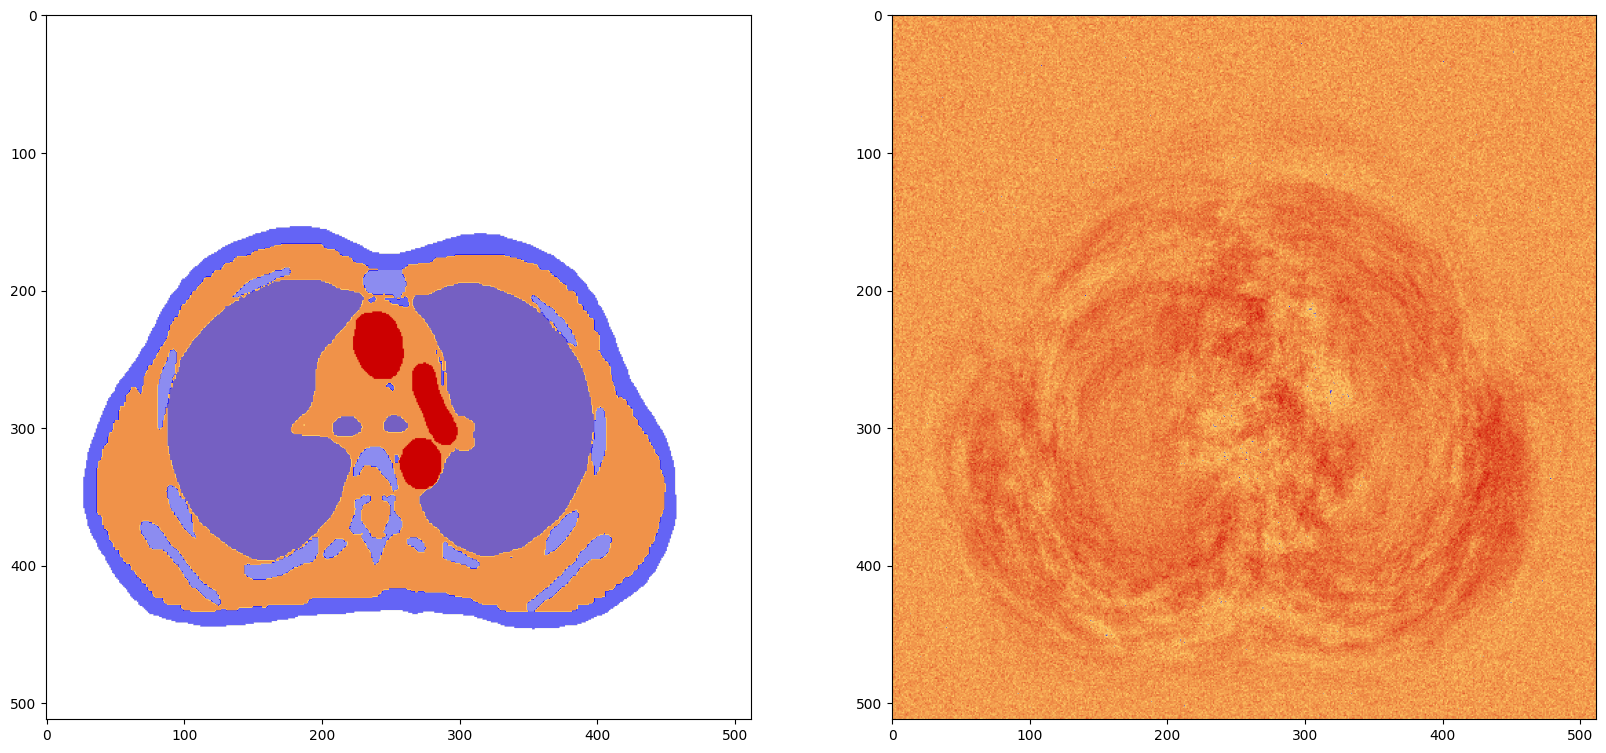

In [30]:
sub = 8
level = 0
fig, axes = plt.subplots(1, 2, figsize=(20,10))

axes[0].imshow(targets[sub,level], cmap=cmap)
axes[1].imshow(preds[sub,level], cmap=cmap)#, vmin=0, vmax=1)